# Assignment 5: Principal Components Analysis  
Jason Adam  

## Assignment Specifications
1. Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
2. Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.
3. Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.
4. Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name.  I MUST have your user name to verify submission status.
5. The experiment we have proposed has a MAJOR design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. Provide your Kaggle.com score and user ID.  
6. Report total elapsed time measures for the training set analysis.  It is sufficient to run a single time-elapsed test for this assignment. In practice, we might consider the possibility of repeated executions of the relevant portions of the programs, much as the Benchmark Example programs do.  
  
## Management Considerations  
 From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. Suppose you were the manager of a data science team responsible for implementing models for computer vision (classification of images analogous to the MINST problem). Would you recommend using PCA as a preliminary to machine learning classification? Explain your thinking.

# Setup & Data Ingest

## Imports

In [0]:
# Basic Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings

# Scikit-Learn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Yellowbrick (visualizations)
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import PrecisionRecallCurve

## Dataframe Creation

In [0]:
# Read in train & test from google cloud storage
train_df = pd.read_csv('http://storage.googleapis.com/kaggle-digit-recognizer/train.csv')
test_df = pd.read_csv('http://storage.googleapis.com/kaggle-digit-recognizer/test.csv')

In [3]:
# First 5 rows
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

## Summary Statistics

In [4]:
# View the shape of the dataframes
print(train_df.shape)
print(test_df.shape) # Missing label

(42000, 785)
(28000, 784)


In [5]:
# Review distribution of labels in train set
train_df.groupby('label')['label'].count()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

## Visualization

In [0]:
# Create function to display one image
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

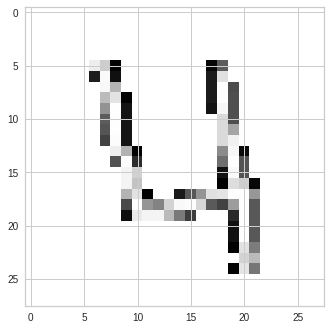

In [7]:
# Generate an image
gen_image(train_df.iloc[3, 1:].values)

# Modeling

## Random Forest - Full Feature Set  
**Assignment Specification 1:** Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

### Training

In [0]:
# Convert training set into X & y
X, y = train_df.iloc[:, 1:], train_df['label']

In [9]:
# Observe the split to ensure it's correct
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [0]:
# Instantiate Random Forest Classifier
rf_clf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', random_state=86)

In [11]:
# Fit the model and record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()

rf_clf.fit(X, y)

end = datetime.datetime.now()
rf_non_pca = end-start
print('Time to train = {}'.format(rf_non_pca))

Time to train = 0:00:02.692648


In [0]:
# Look at feature importance
fi_df = pd.DataFrame({
    'Feature': train_df.iloc[:, 1:].columns,
    'Feature_Importance': rf_clf.feature_importances_
})

In [13]:
# View top 10 most important pixels
fi_df.sort_values('Feature_Importance', ascending=False).head(10)

,Feature,Feature_Importance
406,pixel406,0.014140
350,pixel350,0.011361
375,pixel375,0.009770
570,pixel570,0.009134
462,pixel462,0.008819
456,pixel456,0.008742
487,pixel487,0.008684
234,pixel234,0.008409
351,pixel351,0.008404
408,pixel408,0.008290


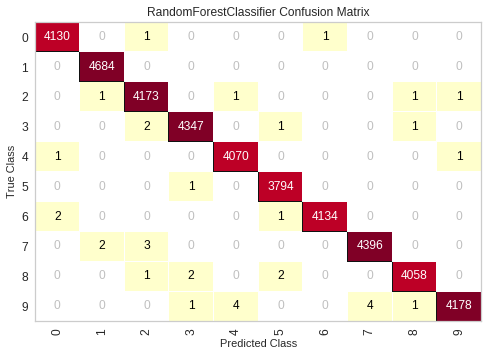

In [14]:
# Create Confusion Matrix
cm = ConfusionMatrix(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
cm.score(X, y)
cm.poof()

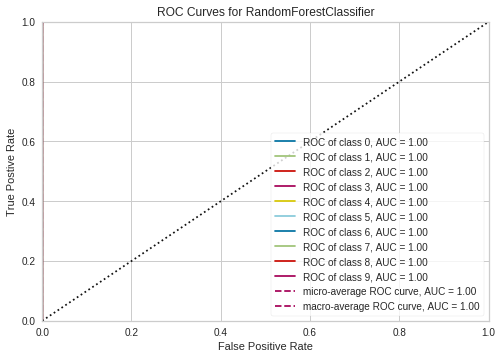

In [15]:
# ROC AUC
roc_auc = ROCAUC(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
roc_auc.score(X, y)
roc_auc.poof()

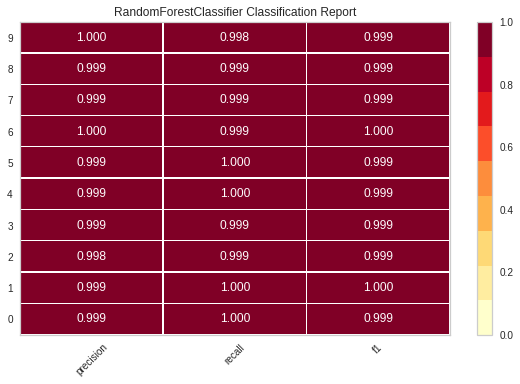

In [16]:
# Classification Report
clf_rpt = ClassificationReport(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
clf_rpt.score(X, y)
clf_rpt.poof()

In [17]:
# Calculate the accuracy
rf_clf.score(X, y)

0.9991428571428571

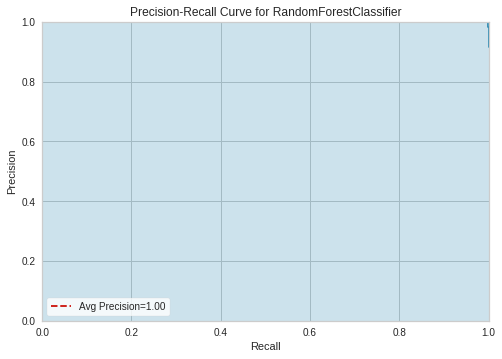

In [18]:
# Precision / Recall Curve
viz_pr = PrecisionRecallCurve(rf_clf)
viz_pr.fit(X, y)
viz_pr.score(X, y)
viz_pr.poof()

### Testing

In [19]:
# Create label predictions on test set
y_pred = rf_clf.predict(test_df)

# View first 10 predictions on test set
y_pred[0:11]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5])

In [20]:
# Create image id for submission
image_id = np.linspace(1, 28000, 28000, dtype=int)
image_id[0:11]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [0]:
# Create dataframe for easier write to csv
req_1_submission = pd.DataFrame({
    "ImageId": image_id,
    "Label": y_pred
})

In [22]:
req_1_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [24]:
# Mount google drive and write the dataframe to csv
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Write to csv for submission
req_1_submission.to_csv(
    "/content/gdrive/My Drive/northwestern/422-msds/week-05/assignment_05/digit-recognizer/req_1_submission.csv",
    index=False
)

### Kaggle Results
Kaggle Score: 0.94300  
Kaggle ID: [JasonAdam](https://www.kaggle.com/jasonadam)

## PCA Full Dataset  
**Assignment Specification 2:** Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.  
  
 **Assignment Specification 3:** Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.  
   
 **Assignment Specification 4:** Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name. I MUST have your user name to verify submission status.

### Apply Principal Component Analysis to Full Dataset

In [0]:
# Bring the test and train together for PCA
full_df = pd.concat([X, test_df], keys=['Train', 'Test'])

In [26]:
# Review Shape
print("Full dataset shape = {}".format(full_df.shape))
full_df.head()

Full dataset shape = (70000, 784)


pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
Train 0       0       0       0       0       0       0       0       0   
      1       0       0       0       0       0       0       0       0   
      2       0       0       0       0       0       0       0       0   
      3       0       0       0       0       0       0       0       0   
      4       0       0       0       0       0       0       0       0   

         pixel8  pixel9  ...  pixel774  pixel775  pixel776  pixel777  \
Train 0       0       0  ...         0         0         0         0   
      1       0       0  ...         0         0         0         0   
      2       0       0  ...         0         0         0         0   
      3       0       0  ...         0         0         0         0   
      4       0       0  ...         0         0         0         0   

         pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  
Train 0         0         0         0         0         0         0  
      1         0         0         0         0         0         0  
      2         0         0         0         0         0         0  
      3         0         0         0         0         0         0  
      4         0         0         0         0         0         0  

[5 rows x 784 columns]

In [0]:
# Scale data prior to PCA
std_scaler = StandardScaler()
scaled_full_df = std_scaler.fit_transform(full_df)

In [28]:
# Run the PCA
start = datetime.datetime.now()

pca = PCA()
pca.fit(scaled_full_df)

end = datetime.datetime.now()
print('Time to train = {}'.format(end-start))

Time to train = 0:00:13.536301


In [29]:
# Calculate the threshold for 95% variability
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("95% of Variability can be accounted for with {} components".format(d))

95% of Variability can be accounted for with 332 components


Text(342, 0.9003881128425844, '332')

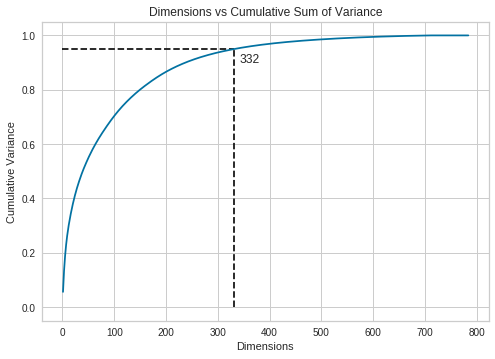

In [30]:
# Plot the PCA Cumulative Variance Sum Curve
x_len = len(pca.explained_variance_ratio_)
x = np.linspace(1, x_len, x_len, dtype=int)
plt.plot(x, cumsum)
plt.hlines(y=cumsum[d], xmin=0, xmax=d, linestyles="dashed")
plt.vlines(x=d, ymin=0, ymax=cumsum[d], linestyles="dashed")
plt.title("Dimensions vs Cumulative Sum of Variance")
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Variance")
plt.annotate(s="{}".format(d), xy=(d+10, cumsum[d]-0.05))

### Training

In [0]:
# Split the train data back out from the combined dataset
scaled_train = pd.DataFrame(scaled_full_df[0:42000], columns=full_df.columns)
scaled_test = pd.DataFrame(scaled_full_df[42000:], columns=full_df.columns)

In [74]:
# Validate the shapes
print(scaled_train.shape)
print(scaled_test.shape)

(42000, 784)
(28000, 784)


In [0]:
# Transform with the optimal dimensions from PCA
pca = PCA(n_components=0.95, random_state=86)

X_train_pca = pca.fit_transform(scaled_train)
X_test_pca = pca.transform(scaled_test)

In [76]:
# Verify the shape
print(X_train_pca.shape)
print(X_test_pca.shape)

(42000, 316)
(28000, 316)


In [77]:
# Train the model on scaled data with PCA applied
start = datetime.datetime.now()

rf_clf.fit(X_train_pca, y)

end = datetime.datetime.now()
print('Time to train = {}'.format(end-start))

Time to train = 0:00:07.510997


In [78]:
# Calculate the accuracy
rf_clf.score(X_train_pca, y)

0.9987857142857143

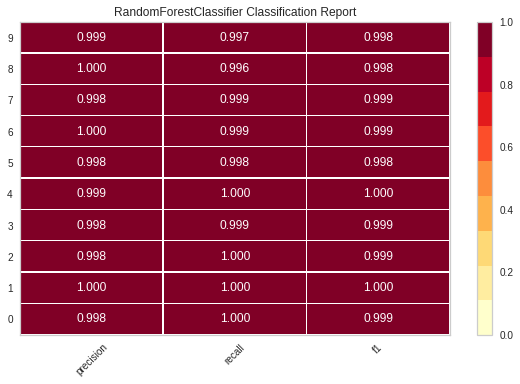

In [79]:
# Classification Report
clf_rpt = ClassificationReport(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
clf_rpt.score(X_train_pca, y)
clf_rpt.poof()

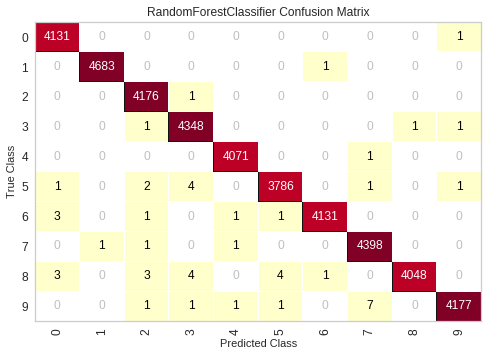

In [80]:
# Create Confusion Matrix
cm = ConfusionMatrix(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
cm.score(X_train_pca, y)
cm.poof()

### Testing

In [81]:
# Create label predictions on test set
y_pred = rf_clf.predict(X_test_pca)

# View first 10 predictions on test set
y_pred[0:11]

array([2, 0, 9, 4, 3, 9, 0, 3, 0, 3, 5])

In [0]:
# Create dataframe for submission
req_3_submission = pd.DataFrame({
    "ImageId": image_id,
    "Label": y_pred
})

In [83]:
# Verify columns are correct
req_3_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [0]:
# Write to csv for submission
req_3_submission.to_csv(
    "/content/gdrive/My Drive/northwestern/422-msds/week-05/assignment_05/digit-recognizer/req_3_submission.csv",
    index=False
)

### Kaggle Results  
Kaggle Score: 0.87357

## PCA Train Only  
**Assignment Specification 5:** The experiment we have proposed has a MAJOR design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. Provide your Kaggle.com score and user ID.  
  
**Assignment Specification 6:** Report total elapsed time measures for the training set analysis. It is sufficient to run a single time-elapsed test for this assignment. In practice, we might consider the possibility of repeated executions of the relevant portions of the programs, much as the Benchmark Example programs do.  
  
 **Flaw in Experiemnt**  
 ***The major flaw in the design of the experiment is applying principal component analysis (PCA) to the entire set of data. The dataset should be split into train and test sets prior to running PCA. To correct the flaw, the train set will be split into a train and validation set. The PCA will be run on these sets prior to making predictions on the test set.***

### Training

In [0]:
# Split the training set into train and validation sets
new_train, validation = train_test_split(train_df, test_size=0.2, random_state=86)

In [91]:
# Verify the split
print(new_train.shape)
print(validation.shape)

(33600, 785)
(8400, 785)


In [0]:
# Split the sets
X_new_train, y_new_train = new_train.iloc[:, 1:], new_train['label']
X_new_val, y_new_val = validation.iloc[:, 1:], validation['label']

In [0]:
# Scale the train & validation data
scld_new_train = std_scaler.fit_transform(X_new_train)
scld_new_val = std_scaler.fit_transform(X_new_val)

In [121]:
# Run the PCA
pca = PCA()

start = datetime.datetime.now()

pca.fit(scld_new_train)

end = datetime.datetime.now()
print('Time to train = {}'.format(end-start))

Time to train = 0:00:05.941294


In [122]:
# Calculate the threshold for 95% variability
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("95% of Variability can be accounted for with {} components".format(d))

95% of Variability can be accounted for with 316 components


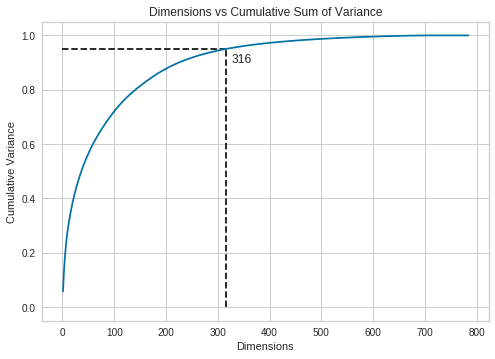

In [123]:
# Plot the PCA Cumulative Variance Sum Curve
x_len = len(pca.explained_variance_ratio_)
x = np.linspace(1, x_len, x_len, dtype=int)
plt.plot(x, cumsum)
plt.hlines(y=cumsum[d], xmin=0, xmax=d, linestyles="dashed")
plt.vlines(x=d, ymin=0, ymax=cumsum[d], linestyles="dashed")
plt.title("Dimensions vs Cumulative Sum of Variance")
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Variance")
plt.annotate(s="{}".format(d), xy=(d+10, cumsum[d]-0.05))
plt.savefig(
    fname="/content/gdrive/My Drive/northwestern/422-msds/week-05/assignment_05/digit-recognizer/pca_dimensions.png"
)

In [0]:
# Apply PCA transformation
pca = PCA(n_components=0.95, random_state=86)

X_new_train_pca = pca.fit_transform(scld_new_train)
X_new_val_pca = pca.transform(scld_new_val)

In [101]:
# Validate the shape
print(X_new_train_pca.shape)
print(X_new_val_pca.shape)

(33600, 316)
(8400, 316)


In [102]:
# Train the model on scaled data with PCA applied
start = datetime.datetime.now()

rf_clf.fit(X_new_train_pca, y_new_train)

end = datetime.datetime.now()
print('Time to train = {}'.format(end-start))

Time to train = 0:00:05.576149


In [103]:
# Calculate the accuracy
rf_clf.score(X_new_train_pca, y_new_train)

0.9984226190476191

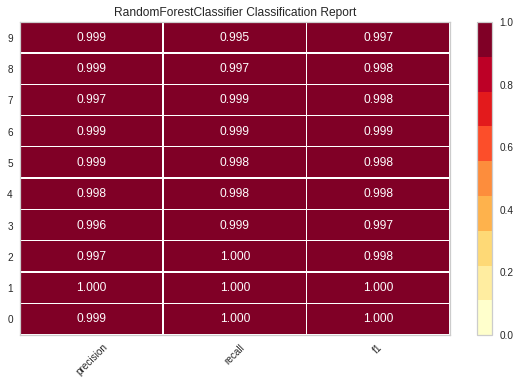

In [104]:
# Classification Report
clf_rpt = ClassificationReport(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
clf_rpt.score(X_new_train_pca, y_new_train)
clf_rpt.poof()

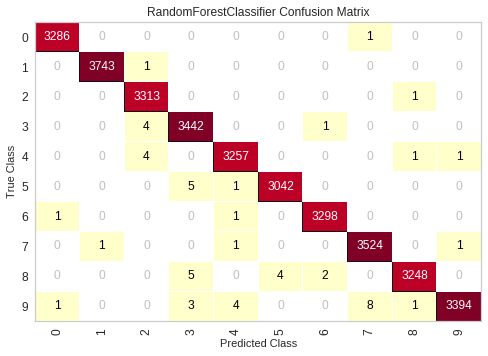

In [105]:
# Create Confusion Matrix
cm = ConfusionMatrix(rf_clf, classes=[0,1,2,3,4,5,6,7,8,9])
cm.score(X_new_train_pca, y_new_train)
cm.poof()

### Validation

In [106]:
# Score the validation set
rf_clf.score(X_new_val_pca, y_new_val)

0.8685714285714285

### Testing

In [0]:
# Scale & Apply PCA to the test data
scaled_test_pca = pca.transform(scaled_test)

In [109]:
# Validate the shape after pca
print(scaled_test_pca.shape)

(28000, 316)


In [110]:
# Create label predictions on test set
y_pred = rf_clf.predict(scaled_test_pca)

# View first 10 predictions on test set
y_pred[0:11]

array([2, 0, 9, 4, 3, 7, 0, 3, 0, 3, 5])

In [0]:
# Create dataframe for submission
req_5_submission = pd.DataFrame({
    "ImageId": image_id,
    "Label": y_pred
})

In [0]:
# Write to csv for submission
req_5_submission.to_csv(
    "/content/gdrive/My Drive/northwestern/422-msds/week-05/assignment_05/digit-recognizer/req_5_submission.csv",
    index=False
)

### Kaggle Results  
Kaggle Score: 0.86600

# Conclusion  
In general, PCA will reduce the number of dimensions needed to maintain a certain level of variation in the original dataset. Management should consider the following:  
* Use PCA as a preliminary step prior to machine learning classification methods.  
* Monitor accuracy reduction with PCA. In this particular instance, there was a significant drop in accuracy (95% with Random Forest vs 86% with PCA) when utilizing PCA prior to applying a random forest classifier.   
* Due to the relatively small dimensions of the dataset, the time difference in these techniques was less than 5 seconds in the training phase.  If the training set were expanded, these time savings could become significant and reduce training time of the classifier.   
* Conduct hyperparameter tuning of the classification technique to increase accuracy.